In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve
import time
import pickle


In [2]:
def calculate_eddy(width=500e3, num_depth_layers=21, eta0=1, L=1e5, H=1000,
                   a=1, b=1, rho0=1025, f0=None,
                   alpha_1=0.01, alpha_2=0.01,
                   T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None,
                   q11=1.0, q12=0.0, q22=1.0):
    """
    Compute 3D geostrophic U,V and fields for an eddy with prescribed
    quadratic-form shape coefficients q11,q12,q22 (constant in z).
    """
    if f0 is None:
        f0 = 2 * 7.29e-5 * np.sin(np.radians(-34))
    g = 9.81

    x = np.linspace(-width/2, width/2, 21)
    y = np.linspace(-width/2, width/2, 21)
    z = np.linspace(-H, 0, num_depth_layers)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    taper = np.exp(Z / taper_depth) if taper_depth is not None else 1.0

    # center shift with depth
    Xc = alpha_1 * Z
    Yc = alpha_2 * Z

    # elliptical radius-squared
    dX = X - Xc
    dY = Y - Yc
    r2Q = q11 * dX**2 + 2*q12 * dX * dY + q22 * dY**2

    phi = np.exp(-r2Q / L**2) * taper

    T = -2 * phi
    S = 1.5 * phi
    P = -rho0 * g * Z

    alpha = 2e-4
    beta  = 8e-4
    sigma = rho0 * (1 - alpha*(T - T0) + beta*(S - 35))
    sigma -= sigma.mean()

    dx, dy = x[1]-x[0], y[1]-y[0]
    dsdx = np.gradient(sigma, dx, axis=0)
    dsdy = np.gradient(sigma, dy, axis=1)

    U =  g/f0 * dsdy * taper
    V = -g/f0 * dsdx * taper

    # flip so z=0 is first index
    U, V, sigma, T, S, P = [np.flip(arr, axis=2) for arr in (U,V,sigma,T,S,P)]
    z = z[::-1]

    # transpose horizontal slices
    for k in range(U.shape[2]):
        U[:,:,k] = U[:,:,k].T
        V[:,:,k] = V[:,:,k].T

    return U, V, sigma, T, S, P, x/1000, y/1000, z/1000


In [3]:
def solve_w(U, V, x, y, z, f=-7.7e-5, N2=5e-3):
    # tic = time.time()

    x = x * 1000
    y = y * 1000
    z = z * 1000

    dx, dy = x[1] - x[0], y[1] - y[0]
    nx, ny, nz = U.shape

    # build Q
    dudz = np.gradient(U, z, axis=2)
    dvdz = np.gradient(V, z, axis=2)
    dvdx = np.gradient(V, dx, axis=0)
    dvdy = np.gradient(V, dy, axis=1)
    dudx = np.gradient(U, dx, axis=0)
    dudy = np.gradient(U, dy, axis=1)

    Qx =  f * (dudz * dvdx + dvdz * dvdy)
    Qy = -f * (dudz * dudx + dvdz * dudy)

    S = 2 * (np.gradient(Qx, dx, axis=0) + np.gradient(Qy, dy, axis=1))
    b = S.ravel(order='F')

    # finite difference operators
    ex, ey = np.ones(nx), np.ones(ny)
    Lx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Ly = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(ny, ny)) / dy**2
    Ix, Iy = eye(nx), eye(ny)

    # nonuniform Lz
    Lz = np.zeros((nz, nz))
    for i in range(1, nz - 1):
        dzm = z[i] - z[i - 1]
        dzp = z[i + 1] - z[i]
        Lz[i, i - 1] =  2 / (dzm * (dzm + dzp))
        Lz[i, i]     = -2 / (dzm * dzp)
        Lz[i, i + 1] =  2 / (dzp * (dzm + dzp))
    Lz = csr_matrix(Lz)
    Iz = eye(nz)

    A = N2 * (kron(kron(Iz, Iy), Lx) + kron(kron(Iz, Ly), Ix)) \
      + f**2 * kron(kron(Lz, Iy), Ix)

    w = spsolve(A.tocsr(), b).reshape((nx, ny, nz), order='F')

    # toc = time.time()
    # print(f"Elapsed time: {toc - tic:.4f} seconds")

    return w
    

In [4]:
def plotter(U, V, w, X, Y, vabs):
    rows, cols = 2, 4
    cmap = plt.get_cmap('coolwarm')
    if vabs is None:
        vabs = np.nanmax(np.abs(w))
    norm = plt.Normalize(vmin=-vabs, vmax=vabs)
    
    fig, axs = plt.subplots(rows, cols, figsize=(3*cols + 1, 3*rows), constrained_layout=True)
    
    for k in range(8):
        ax = axs[k // cols, k % cols]
        if k == 0:
            im = ax.contourf(X, Y, w[:, :, k], cmap=cmap, norm=norm)
        else:
            ax.contourf(X, Y, w[:, :, k], cmap=cmap, norm=norm)
        spacing = 1
        ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
                  U[::spacing, ::spacing, k], V[::spacing, ::spacing, k],
                  color='k', scale=20, alpha=0.4)
        ax.axis('equal')
        ax.set_title(f'Depth {-int(round(z[k]*1000))}m')
    
    # Add communal colorbar to the right
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label(r'w [m Day$^-1$]')
    
    plt.show()


## Circular

#### Non Tilt


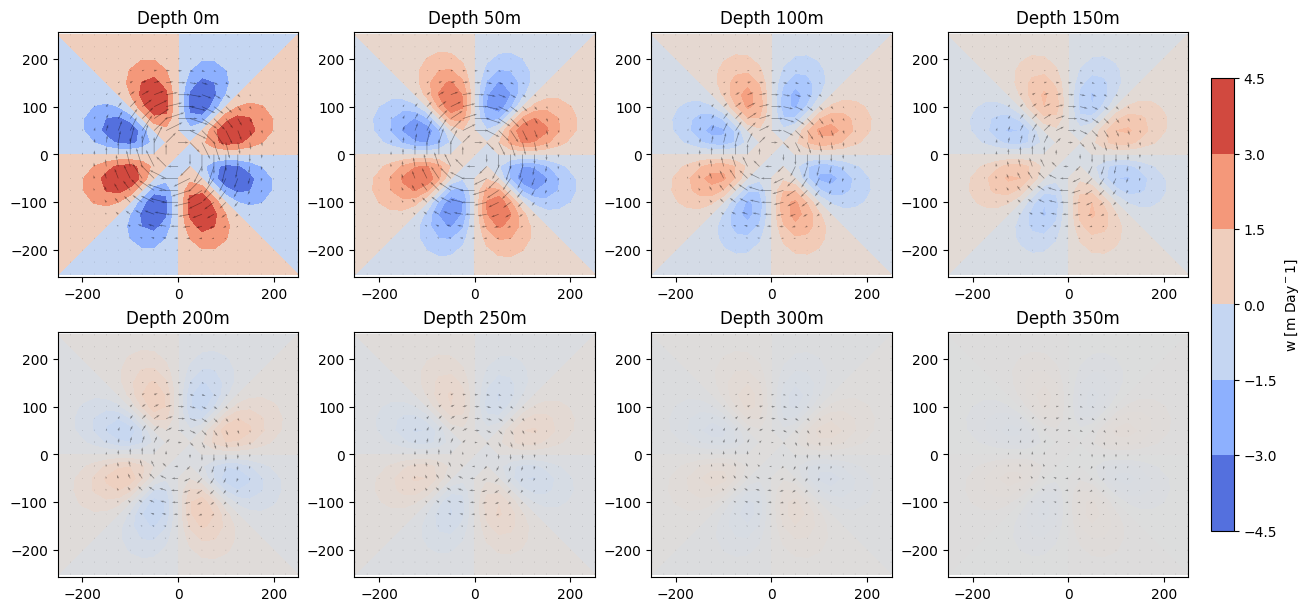

In [5]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400)
X, Y = np.meshgrid(x, y)
w = solve_w(U, V, x, y, z)
w = w * 86400
vabs = 4.5
plotter(U, V, w, X, Y, vabs)

#### Tilt

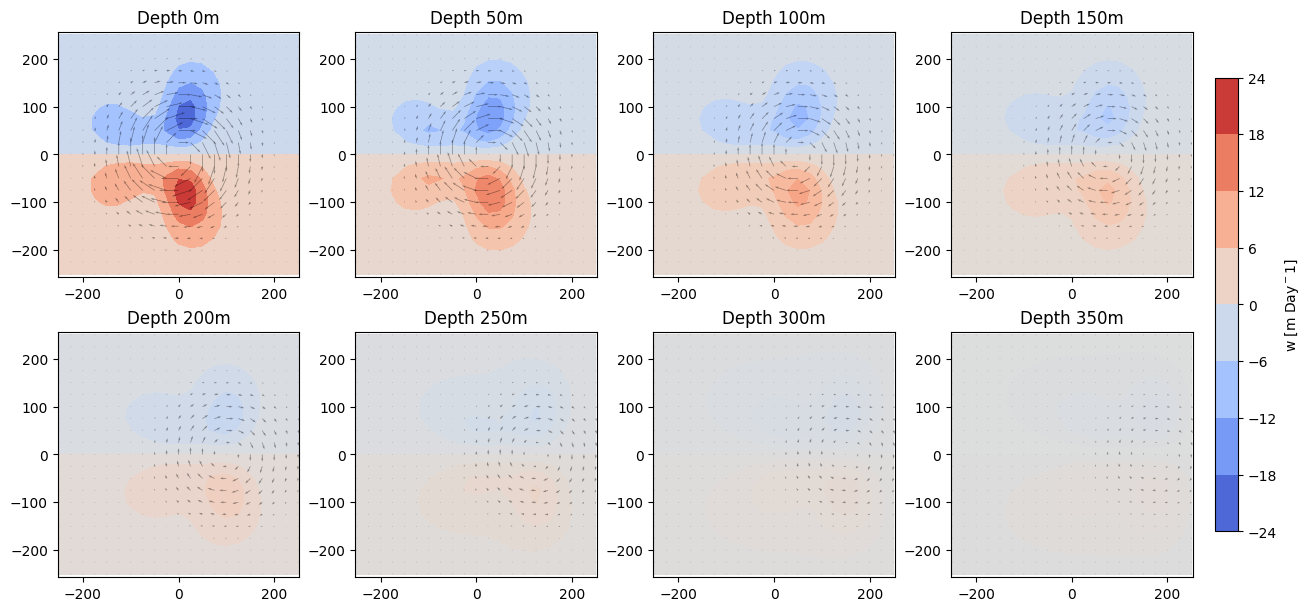

In [6]:
alpha_1 = (x[1]-x[0])/(z[1]-z[0]) # tilt in x direction
U_tilt, V_tilt, *_ = calculate_eddy(taper_depth=400, alpha_1=alpha_1)
w_tilt = solve_w(U_tilt, V_tilt, x, y, z)
w_tilt = w_tilt * 86400
vabs_tilt = 24
plotter(U_tilt, V_tilt, w_tilt, X, Y, vabs_tilt)

## Elliptical

#### Non Tilt

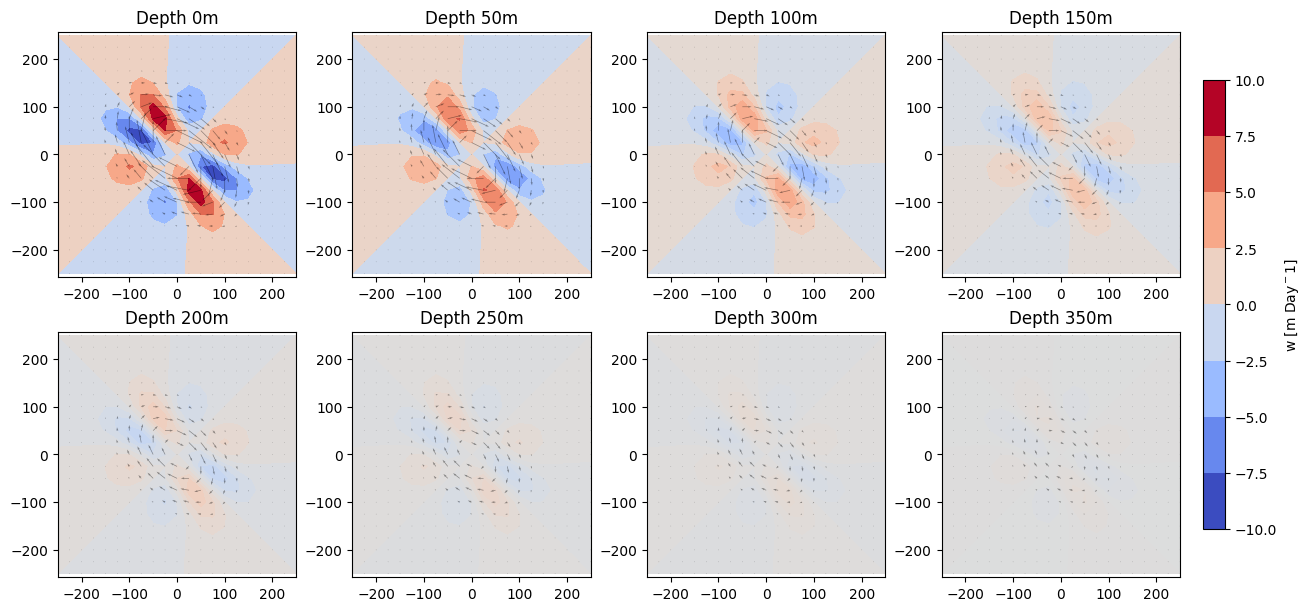

In [7]:
U2, V2, *_ = calculate_eddy(taper_depth=400, q11=2, q22=2, q12=1)
w2 = solve_w(U2, V2, x, y, z)
w2 = w2 * 86400
vabs2 = None
plotter(U2, V2, w2, X, Y, vabs2)


#### Tilt

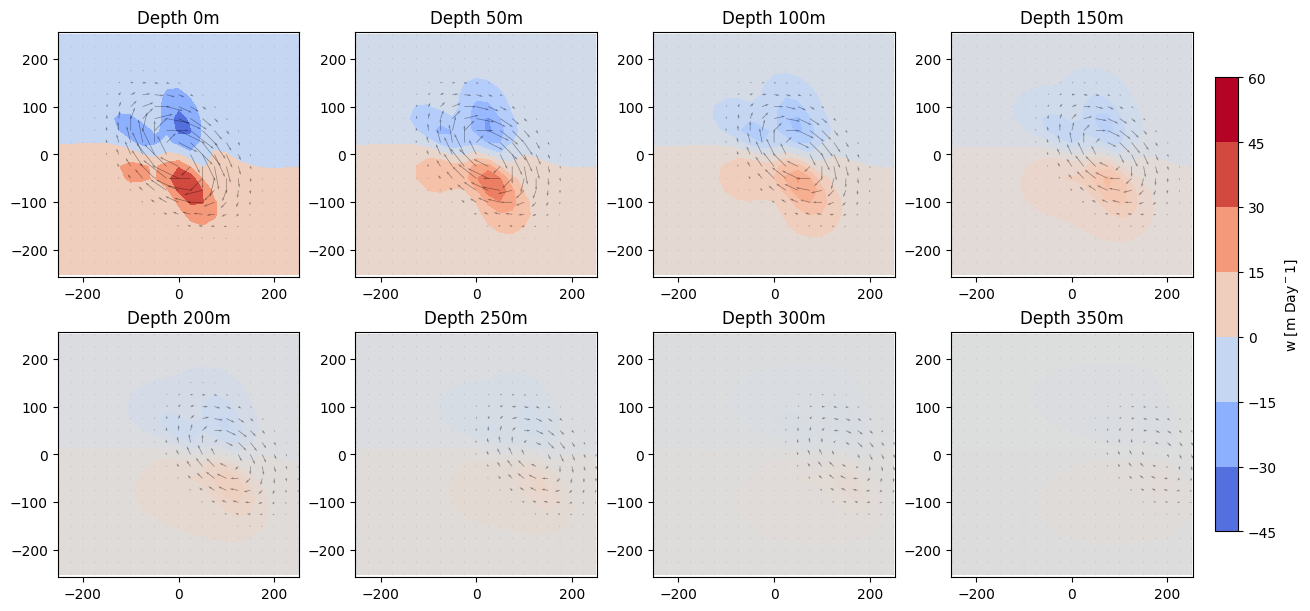

In [8]:
alpha_1 = (x[1]-x[0])/(z[1]-z[0]) # tilt in x direction
U2_tilt, V2_tilt, *_ = calculate_eddy(taper_depth=400, alpha_1=alpha_1, q11=2, q22=2, q12=1)
w2_tilt = solve_w(U2_tilt, V2_tilt, x, y, z)
w2_tilt = w2_tilt * 86400
vabs2_tilt = None
plotter(U2_tilt, V2_tilt, w2_tilt, X, Y, vabs2_tilt)


### Li Plot

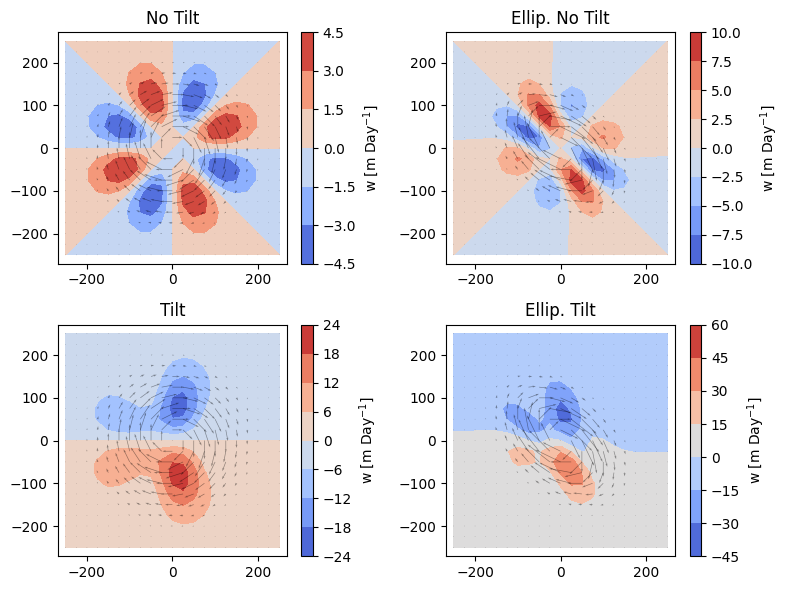

In [9]:
# vmin = min(w.min(), w2.min(), w_tilt.min(), w2_tilt.min())
# vmax = max(w.max(), w2.max(), w_tilt.max(), w2_tilt.max())
vmin = None
vmax = None

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
k = 0
scale = 20
cs0 = axs[0,0].contourf(X, Y, w[:,:,k], cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0,0].quiver(X, Y, U[:,:,k], V[:,:,k], alpha=.4, scale=scale)
axs[0,0].set_title('No Tilt')
cs1 = axs[0,1].contourf(X, Y, w2[:,:,k], cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0,1].quiver(X, Y, U2[:,:,k], V2[:,:,k], alpha=.4, scale=scale)
axs[0,1].set_title('Ellip. No Tilt')
cs2 = axs[1,0].contourf(X, Y, w_tilt[:,:,k], cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[1,0].quiver(X, Y, U_tilt[:,:,k], V_tilt[:,:,k], alpha=.4, scale=scale)
axs[1,0].set_title('Tilt')
cs3 = axs[1,1].contourf(X, Y, w2_tilt[:,:,k], cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[1,1].quiver(X, Y, U2_tilt[:,:,k], V2_tilt[:,:,k], alpha=.4, scale=scale)
axs[1,1].set_title('Ellip. Tilt')

for ax, cs in zip(axs.flat, [cs0, cs1, cs2, cs3]):
    fig.colorbar(cs, ax=ax, label=r'w [m Day$^{-1}$]')
    ax.axis('equal')

plt.tight_layout()
plt.show()


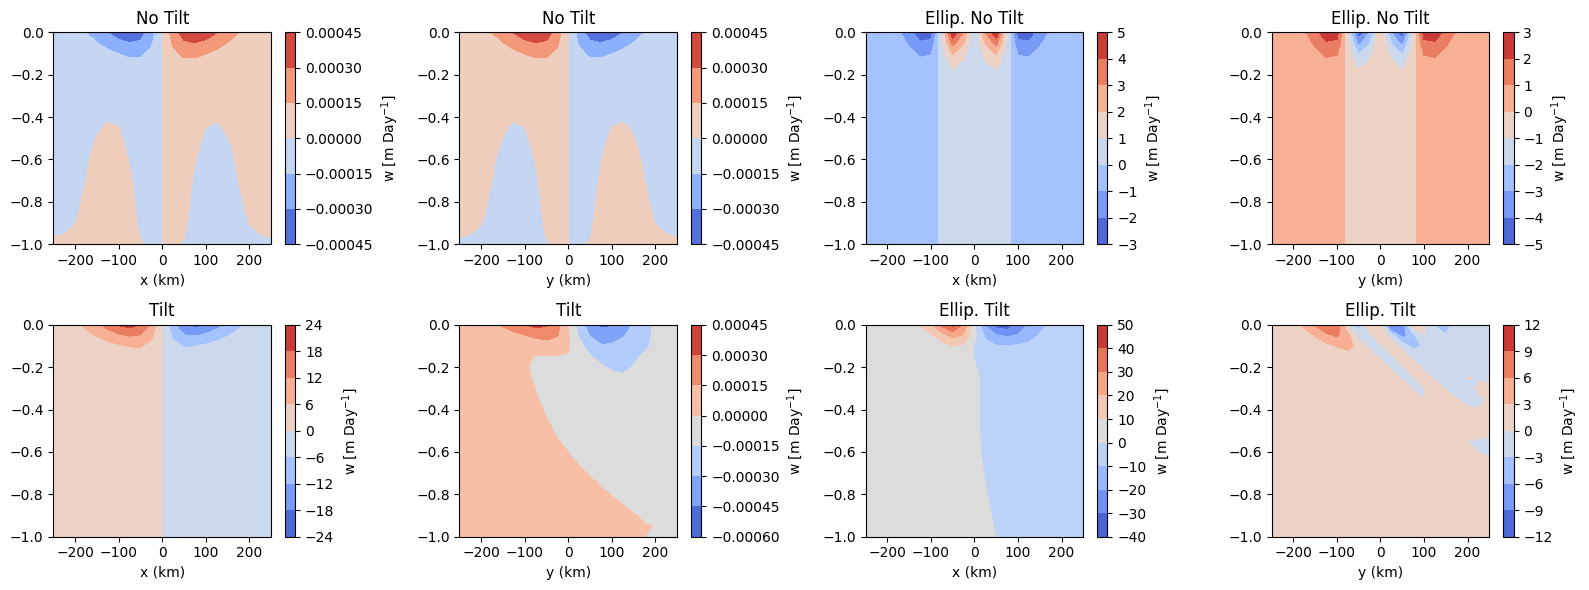

In [10]:
# vmin = min(w.min(), w2.min(), w_tilt.min(), w2_tilt.min())
# vmax = max(w.max(), w2.max(), w_tilt.max(), w2_tilt.max())
vmin = None
vmax = None

fig, axs = plt.subplots(2, 4, figsize=(16, 6))
i = X.shape[0]//2
j = X.shape[1]//2
scale = 20

cs0 = axs[0,0].contourf(x, z, w[:,j,:].T, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0,0].set_title('No Tilt')
axs[0,0].set_xlabel('x (km)')
cs1 = axs[0,1].contourf(y, z, w[i,:,:].T, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0,1].set_title('No Tilt')
axs[0,1].set_xlabel('y (km)')

cs2 = axs[0,2].contourf(x, z, w2[:,j,:].T, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0,2].set_title('Ellip. No Tilt')
axs[0,2].set_xlabel('x (km)')
cs3 = axs[0,3].contourf(y, z, w2[i,:,:].T, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0,3].set_title('Ellip. No Tilt')
axs[0,3].set_xlabel('y (km)')

cs4 = axs[1,0].contourf(x, z, w_tilt[:,j,:].T, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[1,0].set_title('Tilt')
axs[1,0].set_xlabel('x (km)')
cs5 = axs[1,1].contourf(y, z, w_tilt[i,:,:].T, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[1,1].set_title('Tilt')
axs[1,1].set_xlabel('y (km)')

cs6 = axs[1,2].contourf(x, z, w2_tilt[:,j,:].T, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[1,2].set_title('Ellip. Tilt')
axs[1,2].set_xlabel('x (km)')
cs7 = axs[1,3].contourf(y, z, w2_tilt[i,:,:].T, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[1,3].set_title('Ellip. Tilt')
axs[1,3].set_xlabel('y (km)')

for ax, cs in zip(axs.flat, [cs0, cs1, cs2, cs3, cs4, cs5, cs6, cs7]):
    fig.colorbar(cs, ax=ax, label=r'w [m Day$^{-1}$]')
    # ax.axis('equal')

plt.tight_layout()
plt.show()


#### ROMS

In [11]:
with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = list(dic_sample.keys())

df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


## Eddy Streamfunction and Velocity Field

We define an **elliptical Gaussian eddy** using a streamfunction

$$
\psi(x, y) = \exp\left(-\frac{1}{2} \phi(x, y)\right)
$$

where the scalar field $\phi$ is quadratic in $x$ and $y$

$$
\phi(x, y) = q_{11}(x - x_0)^2 + 2q_{12}(x - x_0)(y - y_0) + q_{22}(y - y_0)^2.
$$

This gives an elliptical shape controlled by the symmetric matrix $Q$

$$
Q = \begin{bmatrix}
q_{11} & q_{12} \\
q_{12} & q_{22}
\end{bmatrix}.
$$

The geostrophic velocity field is derived from the streamfunction via

$$
u = -\frac{\partial \psi}{\partial y}, \quad v = \frac{\partial \psi}{\partial x}.
$$

We compute the gradients using the chain rule

$$
\frac{\partial \psi}{\partial x} = -\frac{1}{2} \frac{\partial \phi}{\partial x} \exp\left(-\frac{1}{2} \phi\right), \quad
\frac{\partial \psi}{\partial y} = -\frac{1}{2} \frac{\partial \phi}{\partial y} \exp\left(-\frac{1}{2} \phi\right)
$$

with

$$
\frac{\partial \phi}{\partial x} = 2q_{11}(x - x_0) + 2q_{12}(y - y_0),
$$
$$
\frac{\partial \phi}{\partial y} = 2q_{22}(y - y_0) + 2q_{12}(x - x_0).
$$



In [12]:
def sample_solve_w(df):
    df['x'] = df['x'] - df.iloc[0]['x']
    df['y'] = df['y'] - df.iloc[0]['y']
    
    x_roms = np.linspace(df.x.min()-80, df.x.max()+80, 16)
    y_roms = np.linspace(df.y.min()-80, df.y.max()+80, 16)
    X_roms, Y_roms = np.meshgrid(x_roms, y_roms)
    z_roms = np.array(df['Depth']) / 1000
    
    U_roms = np.zeros((X_roms.shape[0], X_roms.shape[1], len(df)))
    V_roms = np.zeros((X_roms.shape[0], X_roms.shape[1], len(df)))
    for k, (x0, y0, Q) in enumerate(zip(df.x, df.y, df.Q)):
        q11, q12, q22 = Q[0,0], Q[1,0], Q[1,1]
    
        phi = q11*(X_roms-x0)**2 + 2*q12*(X_roms-x0)*(Y_roms-y0) + q22*(Y_roms-y0)**2
        phi_x = 2*q11*(X_roms-x0)+2*q12*(Y_roms-y0)
        phi_y = 2*q22*(Y_roms-y0)+2*q12*(X_roms-x0)
    
        psi_x = -phi_x/2*np.exp(-phi/2)
        psi_y = -phi_y/2*np.exp(-phi/2)
    
        U_roms[:, :, k] = -psi_y
        V_roms[:, :, k] = psi_x
    
    w_roms = solve_w(U_roms, V_roms, x_roms, y_roms, z_roms)
    w_roms = w_roms * 86400
    
    return w_roms, U_roms, V_roms, X_roms, Y_roms, z_roms

# dic_w = {}
# for e, eddy in enumerate(dic_sample.keys()):
#     dic_w[eddy] = {}
#     dic = dic_sample[eddy]
#     for day in dic.keys():
#         dic_w[eddy][day] = {}
#         df = dic[day]
#         if len(df) > 1:
#             w_rel, U_rel, V_rel, X_rel, Y_rel, z_rel = sample_solve_w(df)
#             dic_w[eddy][day]['w'] = w_rel
#             dic_w[eddy][day]['U'] = U_rel
#             dic_w[eddy][day]['V'] = V_rel
#             dic_w[eddy][day]['X'] = X_rel
#             dic_w[eddy][day]['Y'] = Y_rel
#             dic_w[eddy][day]['z'] = z_rel
#             with open('/srv/scratch/z5297792/Chapter2/dic_w.pkl', 'wb') as f:
#                 pickle.dump(dic_w, f)
#     print(f'{e+1}/{len(dic_sample)}')

with open('/srv/scratch/z5297792/Chapter2/dic_w.pkl', 'rb') as f:
    dic_w = pickle.load(f)
        

In [13]:
sample_eddies

['Eddy2749',
 'Eddy8',
 'Eddy2504',
 'Eddy896',
 'Eddy1394',
 'Eddy382',
 'Eddy1967',
 'Eddy926']

In [14]:
eddy = 'Eddy2504'
df_eddies[df_eddies['ID']==int(eddy[4:])]


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
112425,9195,2504,AE,155.295944,-29.120408,142,249,373.624896,1228.259164,0.004764,0.000400,0.003999,0.017527,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112426,9196,2504,AE,155.358689,-29.225019,145,247,383.035433,1219.421968,0.005128,0.000555,0.004156,0.018568,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112427,9197,2504,AE,155.417290,-29.179152,146,248,386.838472,1226.153547,0.004945,0.000724,0.004437,0.018765,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112428,9198,2504,AE,155.452489,-29.171777,147,249,389.823837,1228.091214,0.004752,0.000621,0.004506,0.018517,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112429,9199,2504,AE,155.410462,-29.223687,146,247,387.753758,1221.277634,0.004559,0.000609,0.003799,0.016715,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112496,9266,2504,AE,153.926715,-32.344570,137,172,361.173212,847.149944,0.007304,0.000663,0.001967,0.018543,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112497,9267,2504,AE,153.913446,-32.370828,137,171,360.895416,843.984868,0.007709,0.000241,0.002013,0.019443,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112498,9268,2504,AE,153.884223,-32.416161,137,170,359.854182,838.318333,0.008307,-0.000057,0.002044,0.020702,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
112499,9269,2504,AE,153.907810,-32.360176,137,171,360.025911,844.915418,0.008778,-0.000209,0.001719,0.020993,76,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


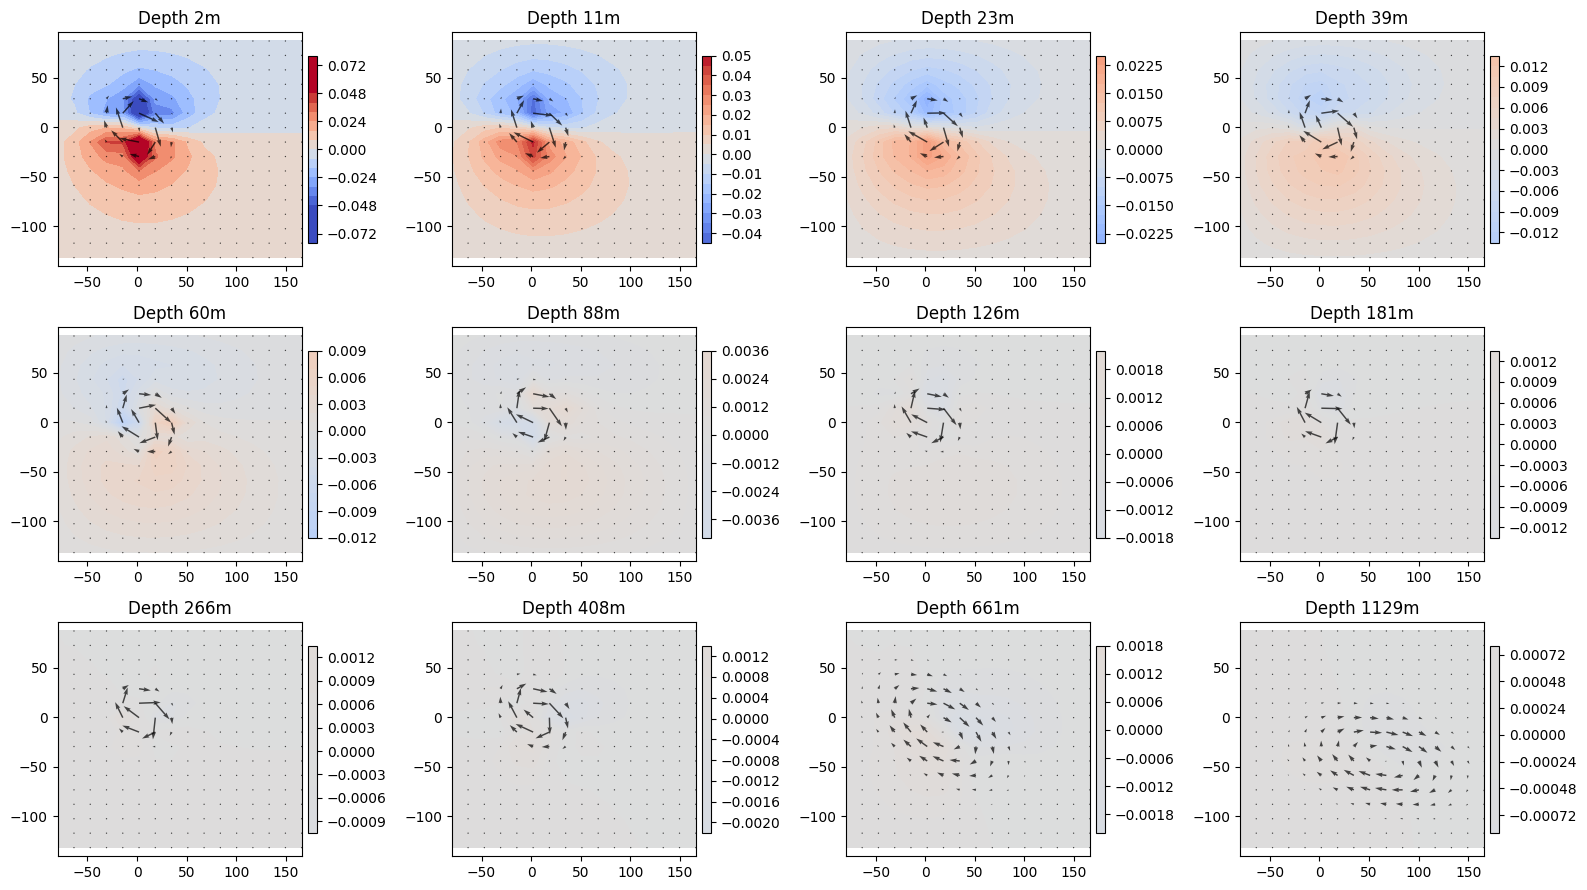

In [21]:
eddy = 'Eddy2504'
day = 'Day9230'

w_rel = dic_w[eddy][day]['w']
U_rel = dic_w[eddy][day]['U']
V_rel = dic_w[eddy][day]['V']
X_rel = dic_w[eddy][day]['X']
Y_rel = dic_w[eddy][day]['Y']
z_rel = dic_w[eddy][day]['z']

rows, cols = 3, 4
fig, axs = plt.subplots(rows, cols, figsize=(4*cols,3*rows))
vabs = .05
width = .006
scale = .5

for p, k in enumerate(range(0, w_rel.shape[-1], 2)):

    ax = axs[p // cols, p % cols]
    cf = ax.contourf(X_rel, Y_rel, w_rel[:,:,k], cmap='coolwarm', vmin=-vabs, vmax=vabs, levels=20)
    spacing = 1
    ax.quiver(X_rel[::spacing, ::spacing], Y_rel[::spacing, ::spacing], U_rel[::spacing, ::spacing, k], V_rel[::spacing, ::spacing, k],
              color='k', scale=scale, alpha=.7, width=width)

    cbar = fig.colorbar(cf, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)
              
    ax.axis('equal')
    ax.set_title(f'Depth {-int(round(z_rel[k]*1000))}m')

plt.tight_layout()
plt.show()


In [16]:
dic_w[eddy].keys()

dict_keys(['Day9195', 'Day9196', 'Day9197', 'Day9198', 'Day9199', 'Day9200', 'Day9201', 'Day9202', 'Day9203', 'Day9204', 'Day9205', 'Day9206', 'Day9207', 'Day9208', 'Day9209', 'Day9210', 'Day9211', 'Day9212', 'Day9213', 'Day9214', 'Day9215', 'Day9216', 'Day9217', 'Day9218', 'Day9219', 'Day9220', 'Day9221', 'Day9222', 'Day9223', 'Day9224', 'Day9225', 'Day9226', 'Day9227', 'Day9228', 'Day9229', 'Day9230', 'Day9231', 'Day9232', 'Day9233', 'Day9234', 'Day9235', 'Day9236', 'Day9237', 'Day9238', 'Day9239', 'Day9240', 'Day9241', 'Day9242', 'Day9243', 'Day9244', 'Day9245', 'Day9246', 'Day9247', 'Day9248', 'Day9249', 'Day9250', 'Day9251', 'Day9252', 'Day9253', 'Day9254', 'Day9255', 'Day9256', 'Day9257', 'Day9258', 'Day9259', 'Day9260', 'Day9261', 'Day9262', 'Day9263', 'Day9264', 'Day9265', 'Day9266', 'Day9267', 'Day9268', 'Day9269', 'Day9270'])

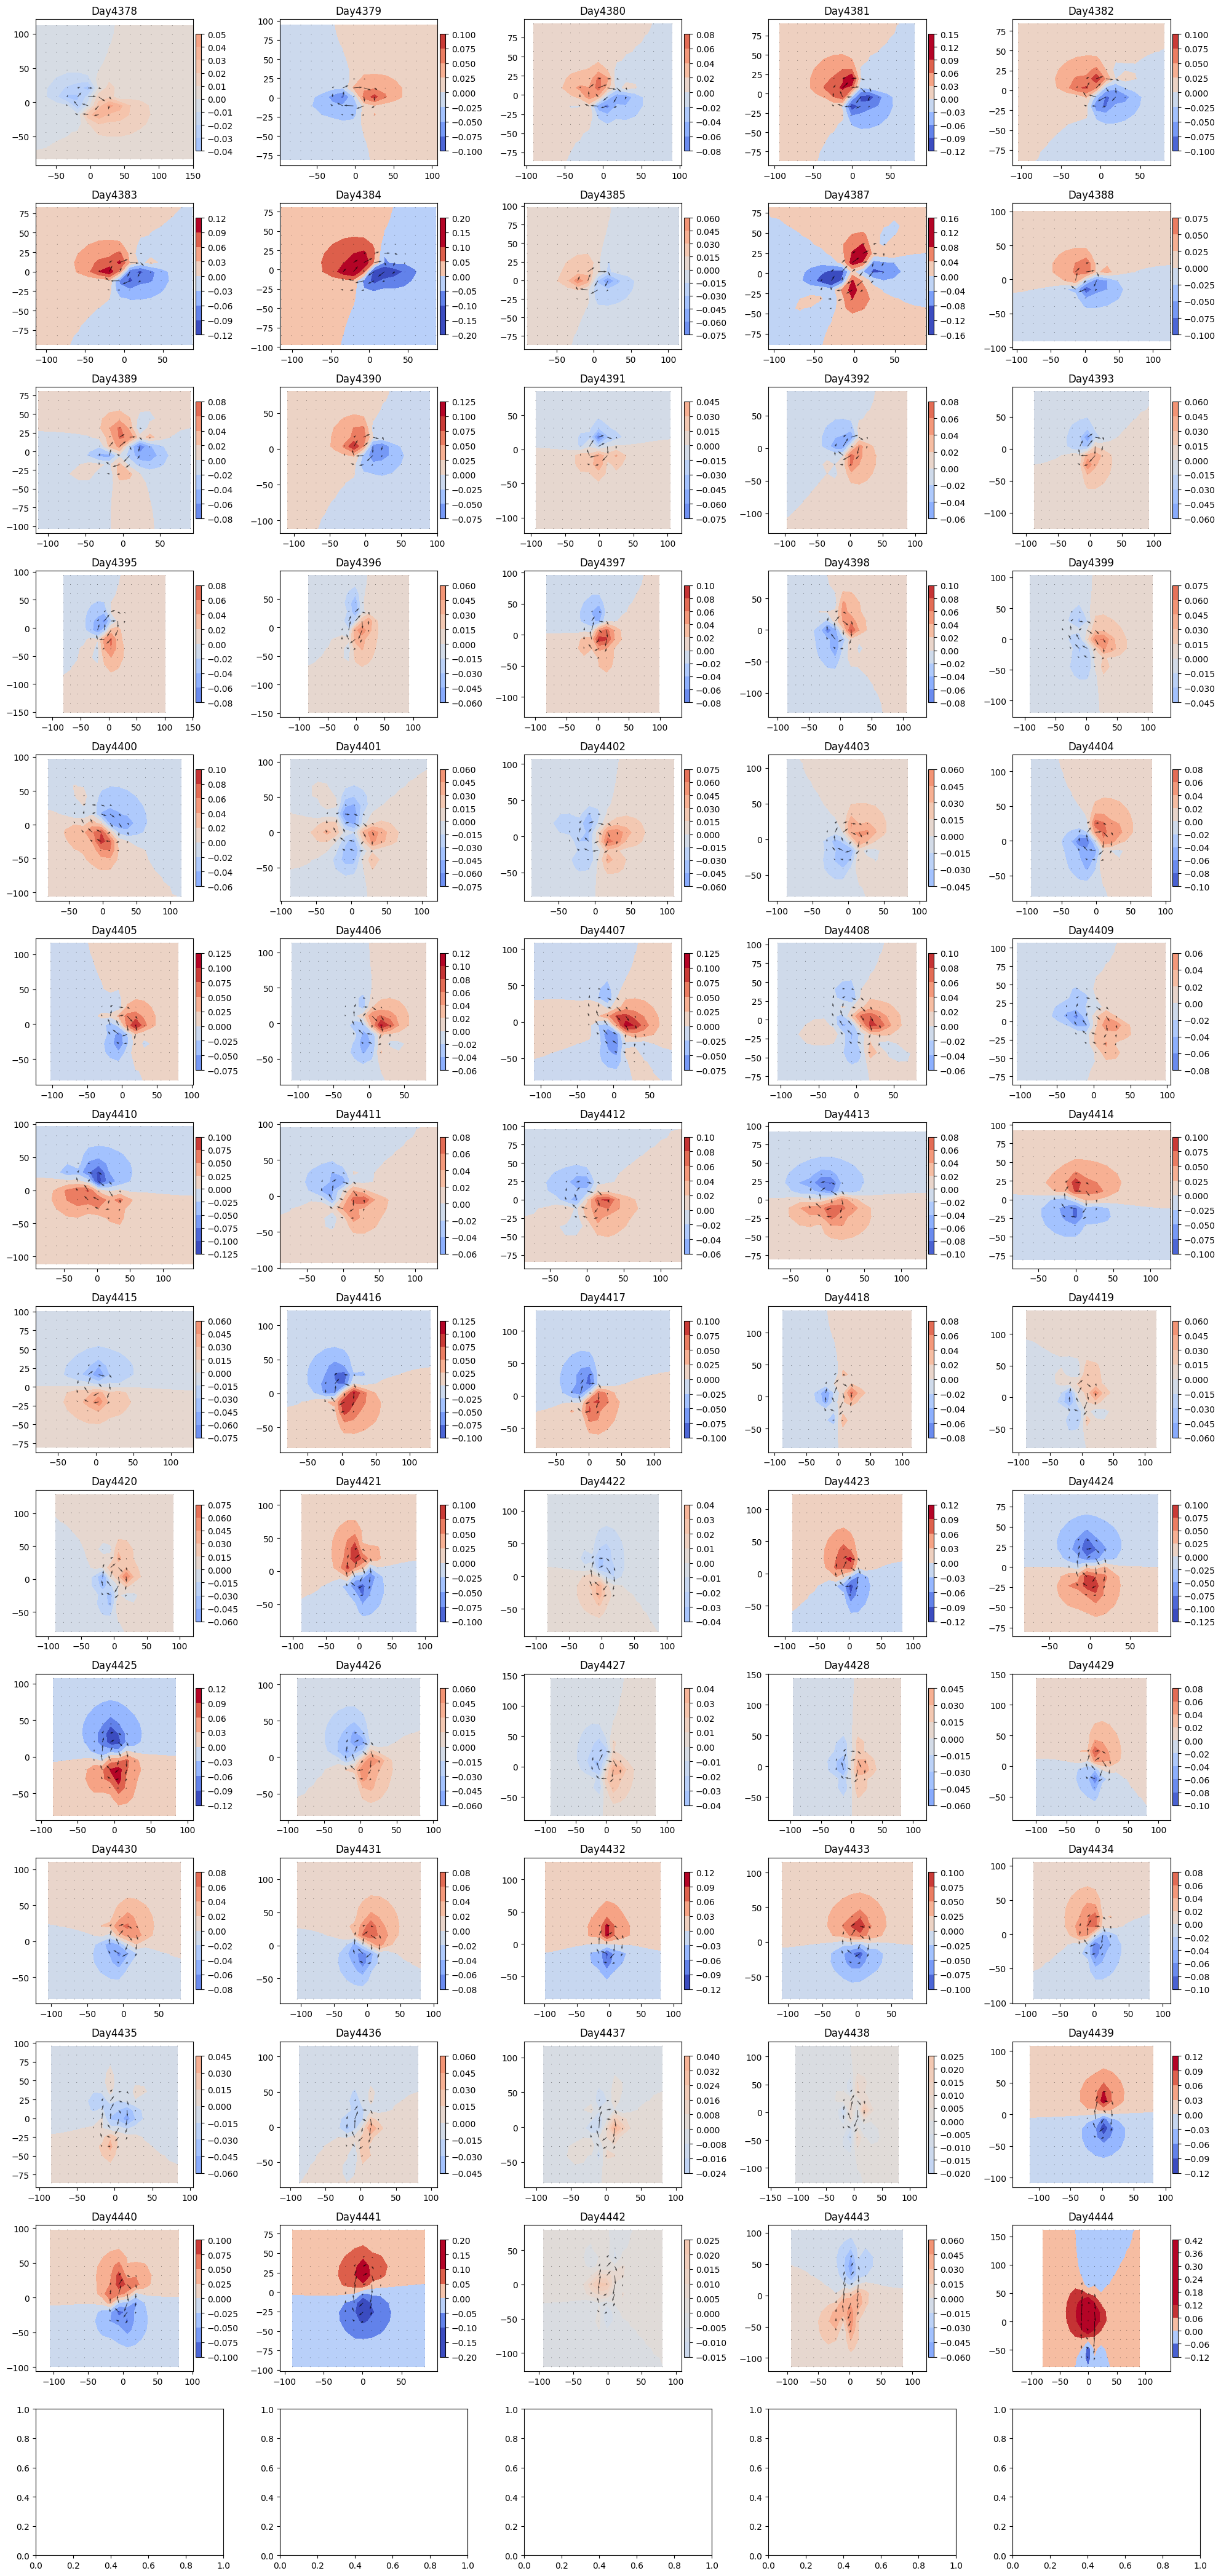

In [17]:
rows, cols = 14, 5
fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
vabs = 0.1

eddy = 'Eddy896'
k = 0

for d, day in enumerate(dic_w[eddy].keys()):
    w_rel = dic_w[eddy][day]['w'][:, :, k]
    U_rel = dic_w[eddy][day]['U'][:, :, k]
    V_rel = dic_w[eddy][day]['V'][:, :, k]
    X_rel = dic_w[eddy][day]['X']
    Y_rel = dic_w[eddy][day]['Y']

    ax = axs[d // cols, d % cols]
    cf = ax.contourf(X_rel, Y_rel, w_rel, cmap='coolwarm', vmin=-vabs, vmax=vabs)
    
    spacing = 1
    ax.quiver(X_rel[::spacing, ::spacing], Y_rel[::spacing, ::spacing],
              U_rel[::spacing, ::spacing], V_rel[::spacing, ::spacing],
              color='k', scale=1, alpha=0.7)

    fig.colorbar(cf, ax=ax, orientation='vertical', shrink=0.8, pad=0.01)
    
    ax.axis('equal')
    ax.set_title(f'{day}')

plt.tight_layout()
plt.show()
